# Петров Сергей Дмитриевич, Вариант 5

In [1]:
import module_lab1 as lab1
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
def likelihood_func(x, M, B):
    delit = 2*np.pi * np.sqrt(np.linalg.det(B))

    for_exp = np.dot(
        (x  - M),
        np.linalg.inv(B)
    )
    for_exp = np.dot(
        for_exp,
        (x - M)
    )


    return np.exp(-for_exp/2)/delit

def create_likelihood_func(M, B):
    def inner_func(x):
        return likelihood_func(x, M, B)
    return inner_func

### Задача 1
Построить байесовскую решающую границу между классами $\Omega 0$ и $\Omega 1$ двумерных нормально распределенных векторов признаков для случая равных корреляционных матриц и равных априорных вероятностей и изобразить ее графически. Вычислить вероятности ошибочной классификации и суммарную вероятность ошибочной классификации в этом случае
    

In [82]:
def create_data_for_class(N:list, M:list, B:list):
    class data:
        def __init__(self, N:list, M:list, B:list):
            temp_N = np.array(N)
            self.aprior_prob = temp_N/temp_N.sum()

            self.vectors = []
            self.likelihood_funcs = []
            for n, m, b in zip(N, M, B):
                var_xi = lab1.create_xi(n)
                self.vectors += [lab1.calc_x(var_xi, m, b)]
                self.likelihood_funcs += [create_likelihood_func(m, b)]

            self.vectors = np.array(self.vectors)

            self.c = np.ones([len(N), len(N)])
            self.c -= np.eye(len(N), len(N), 0)

        def find_borders(self):
            x_min = self.vectors[:, :, 0].min()
            x_max = self.vectors[:, :, 0].max()

            y_min = self.vectors[:, :, 1].min()
            y_max = self.vectors[:, :, 1].max()

            return ([x_min, x_max], [y_min, y_max])

        def plot_dots(self,steps = None):
            borders = self.find_borders()

            if(steps == None):
                plt.xlim(borders[0])
                plt.ylim(borders[1])
                for target, vec in enumerate(self.vectors):
                    plt.scatter(vec[:,0], vec[:,1], label = target)
            else:
                plt.xlim(0, steps[0])
                plt.ylim(0, steps[1])

                vec_copy = self.vectors.copy()

                vec_copy[:,:,0] = (vec_copy[:,:,0] - borders[0][0])/(borders[0][1] - borders[0][0]) * steps[0]
                vec_copy[:,:,1] = (vec_copy[:,:,1] - borders[1][0])/(borders[1][1] - borders[1][0]) * steps[1]

                for target, vec in enumerate(vec_copy):
                    plt.scatter(vec[:,0], vec[:,1], label = target)

            


    return data(N, M, B)

In [109]:
class BiasClassifier:
    def __init__(self, data:create_data_for_class):
        self.data = data

    def vec_prob(self, vec):
        return np.array([apr*likelihood(vec) for apr, likelihood in zip(self.data.aprior_prob, self.data.likelihood_funcs)])
    
    def pred_class(self, vec):
        return np.argmax(self.vec_prob(vec))
    
    def create_pred_img(self, steps = [16, 10], cmap = 'viridis'):
        borders = self.data.find_borders()
        x_linspace = np.linspace(borders[0][0], borders[0][1], steps[0])
        y_linspace = np.linspace(borders[1][0], borders[1][1], steps[1])

        lam = lambda x, y: self.pred_class(np.array([x, y]))
        
        matrix = [[lam(x,y) for x in x_linspace] for y in y_linspace]

        plt.imshow(matrix,cmap = cmap, origin = 'lower')
        self.data.plot_dots(steps)

In [110]:
baies = BiasClassifier(
    create_data_for_class(
        N=[200, 200, 200],
        M=[lab1.M1, lab1.M2, lab1.M3],
        B=[lab1.B_diag_symm, lab1.B_diag_symm, lab1.B_diag_symm]
    )
)

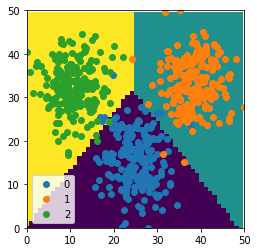

In [111]:
# baies.data.plot_dots()
baies.create_pred_img([50, 50])
plt.legend()
plt.show()